In [1]:
#@title Install Packages
# Install Packages
!pip install pandas
!pip install numpy
!pip install yfinance
!pip install matplotlib
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 402 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#@title Imports Packages
# Packages
import pandas                  as pd
import numpy                   as np
import yfinance                as yf
import matplotlib.pyplot       as plt
import statsmodels.formula.api as smf

from scipy.stats import t, chi2, norm, probplot
from math        import log2
from ipywidgets  import interact

import numpy as np
from   sklearn.linear_model import LinearRegression
import math
import matplotlib.pyplot as plt
import numpy as np

We will be investigating the correlation between different commodities during a specific recessions. The commodities we choose are 

1.   Metals:  Gold, Silver, and Copper
2.   Oil/Gas: Crude Oil, and Natural Gas

The recessions we will investigate is:

1.   The US recession in in early 2000s (dot-com bubble), specifically the 50-days following March 2001.







In [3]:
#@title SETUP - add tickers and dates
# Start date and end date
start_date     = '2001-01-1'
end_date       = '2001-12-31'

# ---- Tickers  for futures contracts ----
# Commodities
t1 = "GC=F" # Gold
t2 = "SI=F" # Silver
t3 = "HG=F" # Copper
t4 = "NG=F" # Natural Gas 
t5 = "CL=F" # Crude Oil

# List of tickers
tickers = [t1, t2, t3, t4, t5]

In [4]:
#@title Download the data and trim to 50-days worth
# Download data
data = {}
for ticker in tickers:
  data[ticker] = yf.download(ticker, start=start_date, end=end_date)

# Your data set needs to include at least 50 trading days per stock symbol
# Keep the last 50-days of data
for ticker in tickers:
  data[ticker] = data[ticker]

# Print the length of the data
print('Length of each set of data', len(data[t1]))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Length of each set of data 246


Now we calculate the log returns of each stock according to the formula$$\log \frac{S^{close}_t}{S^{open}_t}$$

In [5]:
#@title Calculate Log-returns
# Calculate the log returns 
log_return = pd.DataFrame()
normal_return = pd.DataFrame()

for ticker in data:
  log_return[ticker]    = np.log(data[ticker]['Close']/data[ticker]['Open'])
  normal_return[ticker] = data[ticker]['Close']

In [6]:
#@title Histogram Plot of Log-return

# Calculate the number of bins
# Using Sturge's Rule - since the variation in the max and min of our data
# is quite large, we use this rule that does not depend on max or min
def calculate_bins(ticker):
  n      = len(log_return[ticker])
  bins   = 1+np.ceil(log2(n))

  return int(bins)

def plot_histogram(ticker):
  bins = calculate_bins(ticker)
  plt.hist(log_return[ticker], bins=bins)
  plt.show()

In [7]:
#@title Find the CDFs 
def plot_normal_probability(ticker):
  probplot(log_return[ticker], fit=True, plot=plt)
  plt.title(f"{ticker} - Normal Probability Plot")
  plt.show() 

# Find the confidence intervals 
We find the confidence interval for each ticker using the log returns. The confidence intervals then represents the $100(1-\alpha)\%$ confidence interval for the log return of each day, for each given ticker.

In [8]:
def get_CI(alpha):
  # Determines the degree of the confidence interval
  CI_df = pd.DataFrame(columns=[tickers], index=['Mean_lhs', 'Mean_rhs', 
                                                'Variance_lhs', 'Variance_rhs']) 

  # Iterate each ticker in log_return
  for ticker in log_return:
    mean       = np.mean(log_return[ticker]) # Mean
    n          = len(log_return[ticker])     # Number of data points
    s          = np.std(log_return[ticker])  # Standard Deviation
    confidence = 1-alpha                     # Confidence interval 

    # t-distribution calculation
    t_crit = np.abs(t.ppf((1-confidence)/2, (n-1)))

    # Calculate the 100(1-alpha)% confidence interval 
    lhs_m, rhs_m = (mean-s*t_crit/np.sqrt(n), mean+s*t_crit/np.sqrt(n))
    lhs_v, rhs_v = ((n-1)*s**2 / chi2.ppf(1-alpha / 2, n-1), (n-1)*s**2 / chi2.ppf(alpha / 2, n-1))

    # Store in dataframe
    CI_df.loc['Mean_lhs', ticker] = lhs_m
    CI_df.loc['Mean_rhs', ticker] = rhs_m
    CI_df.loc['Variance_lhs', ticker] = lhs_v
    CI_df.loc['Variance_rhs', ticker] = rhs_v
  
  return CI_df

# Function to print intervals
def print_CI(ticker, CI_df):
  lhs_m = float(CI_df.loc['Mean_lhs', ticker])
  rhs_m = float(CI_df.loc['Mean_rhs', ticker])
  lhs_v = float(CI_df.loc['Variance_lhs', ticker])
  rhs_v = float(CI_df.loc['Variance_rhs', ticker])

  print(f'CI mean \t({lhs_m}, {rhs_m})')
  print(f'CI variance \t({lhs_v}, {rhs_v})')

# Regression for one stock

In [9]:
def getTrainingDataForTickerSimpleRegression(ticker):

  XData = []
  yData = []
  tickerDataOG = pd.DataFrame(log_return)
  tickerData = pd.DataFrame(log_return.loc[:, str(ticker)])
  index = 0

  for idx, row in tickerData.iterrows():
    XData.append(index)
    yData.append(row[0])
    index = index + 1
    
  #Calculate cutoff to split data into training and test data with a 75% ratio
  cutoff = math.floor(0.75 * len(XData))

  #Split the data into training and testing sets
  Xtrain = XData[:cutoff]
  Xtest = XData[cutoff:]
  ytrain = yData[:cutoff]
  ytest = yData[cutoff:]

  #Perform regression
  reg = LinearRegression().fit(np.array(Xtrain).reshape(-1, 1), ytrain)
  score = reg.score(np.array(Xtest).reshape(-1, 1), ytest) 
  intercept = reg.intercept_
  coef = reg.coef_

  #Plot the training data
  print("Line of best fit")
  fig1 = plt.figure()
  plt.scatter(Xtrain, ytrain, label='training data', color='grey') 

  #Plot the line of best fit
  x = np.array(range(0,200))
  y = x*coef + intercept
  plt.plot(x, y, label='Line of best fit', color='black')
  leg = plt.legend(loc='upper left')

  return score, intercept, coef[0], fig1

# Regression for two insturments


In [10]:
def logReturnBetweenTwo(ticker1, ticker2):
  #Ticker1 prices plotted on the x axis
  #Ticker2 prices plotted on the y axis
  XData = []
  yData = []
  tickerDataOG = pd.DataFrame(log_return)
  tickerData1 = pd.DataFrame(log_return.loc[:, str(ticker1)])
  tickerData2 = pd.DataFrame(log_return.loc[:, str(ticker2)])

  for idx, row in tickerData1.iterrows():
    XData.append(row[0])
  for idx, row in tickerData2.iterrows():
    yData.append(row[0])
  
  #Divide data into training and testing sets
  cutoff = math.floor(0.75 * len(XData))
  Xtrain = XData[:cutoff]
  Xtest = XData[cutoff:]
  ytrain = yData[:cutoff]
  ytest = yData[cutoff:]

  #Perform linear regression
  reg   = LinearRegression().fit(np.array(Xtrain).reshape(-1, 1), ytrain)
  score = reg.score(np.array(Xtest).reshape(-1, 1), ytest) 
  intercept = reg.intercept_
  coef      = reg.coef_

  # Plot the training data
  print("Line of best fit")
  fig1 = plt.figure()
  plt.scatter(Xtrain, ytrain, label='training data', color='grey') 

  #Plot the line of best fit
  x = (np.array(range(-4,4))/100)
  y = x*coef + intercept
  plt.plot(x, y, label='Line of best fit', color='black')
  leg = plt.legend(loc='upper left')

  return score, intercept, coef[0], fig1

# Hypotesis Testing
$H_0: \mu_1 - \mu_2 = 0$ \\
$H_1: \mu_1 - \mu_2 \neq 0$

Test is 
$$-Z_{\alpha/2} \le \frac{\bar{x}-\bar{y}}{\sqrt{\frac{S_x^2}{n_1}+\frac{S_y^2}{n_2}}} \le Z_{\alpha/2}$$

In [11]:
def test_hypothesis(alpha, t1, t2):
    m1 = np.mean(log_return[t1])
    m2 = np.mean(log_return[t2])

    # Length of data
    n1 = len(log_return[t1])
    n2 = len(log_return[t2])

    # Variance of the sample
    # ddof=1 means we use n-1 to calculate the std
    # (Degrees of Freedom)
    s1 = np.std(log_return[t1], ddof=1)**2
    s2 = np.std(log_return[t2], ddof=1)**2

    # Normalize
    test_stat = (m1-m2)/np.sqrt((s1/n1)+(s2/n2))

    # Confidence interval 
    lhs = norm.ppf(alpha/2)
    rhs = -norm.ppf(alpha/2)

    # Print results
    print('Test statistic:', test_stat)
    print(f'CI: ({lhs}, {rhs})')
    print(f'Confidence interval of {round((100-alpha*100),2)}%')

    # Check if reject or not
    if lhs <= test_stat <= rhs:
        print("Do not reject the null hypothesis\n")
    else:
        print("We reject the null hypothesis\n")

# Select Desired Ticker

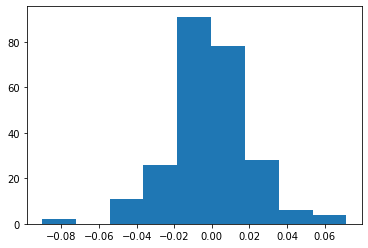

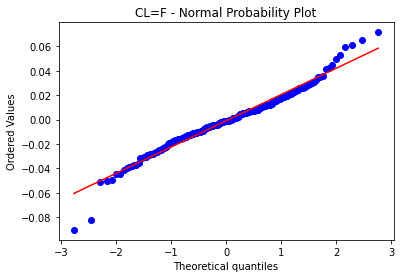

CI mean 	(-0.003662656368559891, 0.0017745760002297615)
CI variance 	(0.0003955765437776227, 0.0005640957115420063)
Line of best fit

Intercept:	 0.0029451008257134585
Coefficent:	 -3.5631788674094434e-05
R-squared:	 -0.010510488941555707


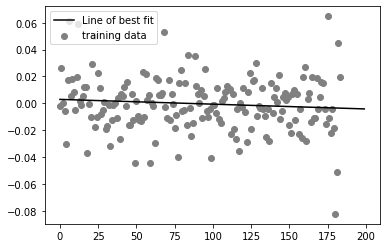

In [12]:
# Out of the given tickers (t1, t2, t3, t4, t5)
# choose two to run the tests on
ticker1 = t5

# Confidence interval, between 0 and 1
alpha = 0.05

# Plot the histogram
plot_histogram(ticker1)

# Plot the normal probability plot
plot_normal_probability(ticker1)

# Print Confidence Intervals
CI_df = get_CI(alpha)
print_CI(ticker1, CI_df)

# Regression for ticker1
score, intercept, coef, fig1 = getTrainingDataForTickerSimpleRegression(ticker1)
fig1.show()
print('\nIntercept:\t', intercept)
print('Coefficent:\t', coef)
print('R-squared:\t', score)

Test statistic: -0.8619239165689978
CI: (-1.9599639845400545, 1.9599639845400545)
Confidence interval of 95.0%
Do not reject the null hypothesis

Line of best fit

Intercept:	 0.00040474463534913443
Coefficent:	 0.036163261744247735
R-squared:	 0.01116262369194565


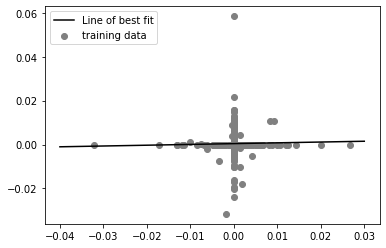

In [13]:
# Choose two tickers to compare
ticker1 = t1
ticker2 = t2

# Hypothesis testing
alpha = 0.05
test_hypothesis(alpha, t1, t2)

# Regression for the log_return of two tickers
score, intercept, coef, fig1 = logReturnBetweenTwo(ticker1, ticker2)
fig1.show()
print('\nIntercept:\t', intercept)
print('Coefficent:\t', coef)
print('R-squared:\t', score)